In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://076923.github.io/posts/Python-opencv-21/
def binaryImageCanny(grayImage):
    canny = cv2.Canny(grayImage, 20, 150)
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE);
    
    for contour in contours:
        cv2.drawContours(canny, [contour], 0, (255, 255, 255), -1)
       
    print(len(contours))
    return canny


In [3]:
def binaryImageAdaptiveThresh(grayImage):
    blured = cv2.medianBlur(grayImage, 5);
    thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2)
    se1 = np.ones((3, 3), np.uint8)
    se2 = np.ones((5, 5), np.uint8)
    
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, se1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, se2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, se1)
    
    thresh = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE);
    for contour in contours:
        cv2.drawContours(thresh, [contour], 0, (255, 255, 255), -1)        
    thresh = cv2.bitwise_not(thresh)

    se3 = np.ones((13, 13), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, se3)
    
    thresh = cv2.bitwise_not(thresh)
    
    return thresh

In [4]:
def resizeFixRate(image, width):
    img_width = image.shape[1]
    imgRatio = width / img_width 
    return cv2.resize(image, dsize=(0, 0), fx=imgRatio, fy=imgRatio, interpolation=cv2.INTER_LINEAR)

In [5]:
def getContours(binaryImage):
    return cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE);

In [6]:
def shadowRemove(image):
    # covert the BGR image to an YCbCr image
    y_cb_cr_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # copy the image to create a binary mask later
    binary_mask = np.copy(y_cb_cr_img)

    # get mean value of the pixels in Y plane
    y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

    # get standard deviation of channel in Y plane
    y_std = np.std(cv2.split(y_cb_cr_img)[0])

    # classify pixels as shadow and non-shadow pixels
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):

            if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
                # paint it white (shadow)
                binary_mask[i, j] = [255, 255, 255]
            else:
                # paint it black (non-shadow)
                binary_mask[i, j] = [0, 0, 0]

    # Using morphological operation
    # The misclassified pixels are
    # removed using dilation followed by erosion.
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(binary_mask, kernel, iterations=1)

    # sum of pixel intensities in the lit areas
    spi_la = 0

    # sum of pixel intensities in the shadow
    spi_s = 0

    # number of pixels in the lit areas
    n_la = 0

    # number of pixels in the shadow
    n_s = 0

    # get sum of pixel intensities in the lit areas
    # and sum of pixel intensities in the shadow
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
                spi_la = spi_la + y_cb_cr_img[i, j, 0]
                n_la += 1
            else:
                spi_s = spi_s + y_cb_cr_img[i, j, 0]
                n_s += 1

    # get the average pixel intensities in the lit areas
    average_ld = spi_la / n_la

    # get the average pixel intensities in the shadow
    average_le = spi_s / n_s

    # difference of the pixel intensities in the shadow and lit areas
    i_diff = average_ld - average_le

    # get the ratio between average shadow pixels and average lit pixels
    ratio_as_al = average_ld / average_le

    # added these difference
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

                y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                 y_cb_cr_img[i, j, 2] + ratio_as_al]

    # covert the YCbCr image to the BGR image
    final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)
    return final_image

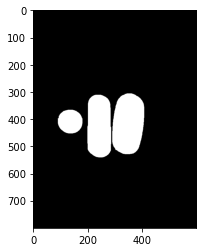

In [7]:
image = cv2.imread("images/pills_1.jpg")
image = resizeFixRate(image, 600)

# fix_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(fix_img)

grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binaryImage = binaryImageAdaptiveThresh(grayImage)
plt.imshow(binaryImage, cmap='gray')

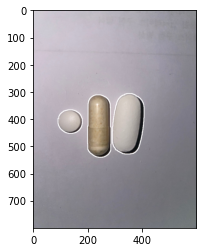

In [8]:
contours, hirarachy = getContours(binaryImage)
for contour in contours:
    cv2.drawContours(image, [contour], 0, (255, 255, 255), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [9]:
#final_image = cv2.cvtColor(shadowRemove(image),cv2.COLOR_BGR2RGB)
#plt.imshow(final_image)

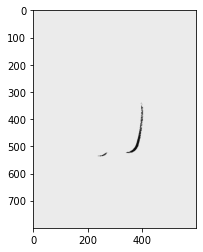

In [42]:
# https://www.programmersought.com/article/61027815338/
arr = np.array([1,0,1,1])
res = arr == 0
arr[res] = 10

test_image = cv2.imread("images/pills_1.jpg",0)
test_image = resizeFixRate(test_image, 600)
test_image[test_image > 30] = 255

pixel = int(np.mean(test_image[test_image>100]))
test_image[test_image>20] = pixel-20
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
plt.imshow(test_image)



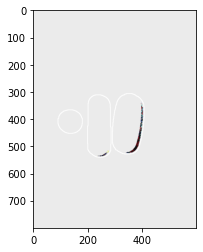

In [44]:
image[image<20] = pixel
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

test_image = test_image + image
contours, hirarachy = getContours(binaryImage)
for contour in contours:
    cv2.drawContours(test_image, [contour], 0, (255, 255, 255), 2)

plt.imshow(test_image)


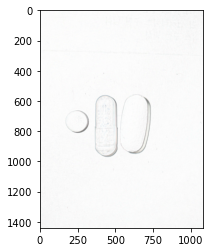

In [56]:
img = cv2.imread("images/pills_1.jpg",-1);

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.imshow(result)


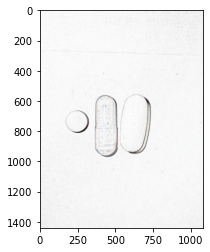

In [57]:
plt.imshow(result_norm)